# Work on traffic_signs

In [2]:
!pip install opencv-contrib-python
!pip install numpy
!pip install scikit-learn
!pip install scikit-image
!pip install imutils
!pip install matplotlib
!pip install tensorflow

  Using cached opencv_contrib_python-4.5.5.62-cp36-abi3-win_amd64.whl (42.2 MB)
  Using cached threadpoolctl-3.0.0-py3-none-any.whl (14 kB)
  Using cached joblib-1.1.0-py2.py3-none-any.whl (306 kB)
  Using cached imageio-2.13.5-py3-none-any.whl (3.3 MB)
  Using cached cycler-0.11.0-py3-none-any.whl (6.4 kB)
  Attempting uninstall: decorator
    Found existing installation: decorator 5.1.0
    Uninstalling decorator-5.1.0:
      Successfully uninstalled decorator-5.1.0
  Using cached imutils-0.5.4.tar.gz (17 kB)
  Created wheel for imutils: filename=imutils-0.5.4-py3-none-any.whl size=25858 sha256=00381aa39f4ba287d987a4b3ab3a53724a8405ee93f49833032b7d2995f93704
  Stored in directory: c:\users\kevin\appdata\local\pip\cache\wheels\f5\0c\3a\61b992f7aa85de40f339e6d4970d91dddb103dd0ad6c5d58f2
Successfully built imutils
  Using cached tensorboard-1.15.0-py3-none-any.whl (3.8 MB)
  Using cached tensorflow_estimator-1.15.1-py2.py3-none-any.whl (503 kB)
  Attempting uninstall: tensorflow-estimat

In [17]:
base_path = "D:\GTSRB Dataset\gtsrb"
save_path = "./trafficsignnet.model"
plot_path = "./plot.png"
test_path = "./Test/"
example_path = "./examples"

In [18]:
# import the necessary packages
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
class TrafficSignNet:
    @staticmethod
    def build(width, height, depth, classes):
        model = Sequential()
        inputShape = (height, width, depth)
        chanDim = -1
        
        # CONV => RELU => BN => POOL
        model.add(Conv2D(8, (5, 5), padding="same",input_shape=inputShape))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        
        # first set of (CONV => RELU => CONV => RELU) * 2 => POOL
        model.add(Conv2D(16, (3, 3), padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(Conv2D(16, (3, 3), padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(MaxPooling2D(pool_size=(2, 2)))
                  
        # second set of (CONV => RELU => CONV => RELU) * 2 => POOL
        model.add(Conv2D(32, (3, 3), padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(Conv2D(32, (3, 3), padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(MaxPooling2D(pool_size=(2, 2)))
                  
        # first set of FC => RELU layers
        model.add(Flatten())
        model.add(Dense(128))
        model.add(Activation("relu"))
        model.add(BatchNormalization())
        model.add(Dropout(0.5))
                  
        # second set of FC => RELU layers
        model.add(Flatten())
        model.add(Dense(128))
        model.add(Activation("relu"))
        model.add(BatchNormalization())
        model.add(Dropout(0.5))
                  
        # softmax classifier
        model.add(Dense(classes))
        model.add(Activation("softmax"))
                  
        return model

In [19]:
#pip install matplotlib


In [20]:
import matplotlib
matplotlib.use("Agg")
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report
from skimage import transform
from skimage import exposure
from skimage import io
import matplotlib.pyplot as plt
import numpy as np
import argparse
import random
import os
import time
import cv2

In [21]:
#function to load the dataset from the csv.
def load(basePath, csvPath):
    
    data = []
    labels = []
    rows = open(csvPath).read().strip().split("\n")[1:]
    #shuffling rows to shuffle classes
    random.shuffle(rows)
    
    # loop over the rows
    for (i, row) in enumerate(rows):
        if i % 1000 == 0:
            print("[INFO] processed {} total images".format(i))
       
        #split each row
        (label, imagePath) = row.strip().split(",")[-2:]
        
        #load each path
        imagePath = os.path.sep.join([basePath, imagePath])
        image = cv2.imread(imagePath,cv2.IMREAD_GRAYSCALE)
        
        # resize the image to be 32x32 pixels and 
        # applying Contrast Limited Adaptive Histogram Equalization (CLAHE)
        image = transform.resize(image, (32, 32))
        image = exposure.equalize_adapthist(image, clip_limit=0.1)
        data.append(image)
        labels.append(int(label))
        
    # convering to np array
    data = np.array(data)
    labels = np.array(labels)

    return (data, labels)

In [22]:
# derive training and testing CSV paths
trainPath = os.path.sep.join([base_path, "Train.csv"])
testPath = os.path.sep.join([base_path, "Test.csv"])

# load the training and testing data
print("[INFO] loading training and testing data...")
(trainX, trainY) = load(base_path, trainPath)
(testX, testY) = load(base_path, testPath)

[INFO] loading training and testing data...
[INFO] processed 0 total images
[INFO] processed 1000 total images
[INFO] processed 2000 total images
[INFO] processed 3000 total images
[INFO] processed 4000 total images


KeyboardInterrupt: 

In [ ]:
#setting parameters for training:
NUM_EPOCHS = 30
INIT_LR = 1e-3
BS = 64

#this is an arbitary name file that was found with the dataset. 
labelNames = open("signnames.csv").read().strip().split("\n")[1:]
labelNames = [l.split(",")[1] for l in labelNames]

# scale data to the range of [0, 1]
trainX = trainX.astype("float32") / 255.0
testX = testX.astype("float32") / 255.0

# one-hot encode the training and testing labels
numLabels = len(np.unique(trainY))
trainY = to_categorical(trainY, numLabels)
testY = to_categorical(testY, numLabels)

#accounting for the skewed classes
classTotals = trainY.sum(axis=0)
classWeight = dict()
# loop over all classes and calculate the class weight
for i in range(0, len(classTotals)):
    classWeight[i] = classTotals.max() / classTotals[i]

In [ ]:
trainY.shape

In [ ]:
trX = trainX[:,:,:,np.newaxis]
teX = testX[:,:,:,np.newaxis]
# trY = trainY[:,:,:,np.newaxis]
# trY = testX[:,:,:,np.newaxis]

In [ ]:
#data augmentation
aug = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.15,
    horizontal_flip=False,
    vertical_flip=False,
    fill_mode="nearest")

# initialize and compiiling
print("[INFO] compiling model...")
opt = Adam(learning_rate=INIT_LR, decay=INIT_LR / (NUM_EPOCHS * 0.5))
model = TrafficSignNet.build(width=32, height=32, depth=1,
        classes=numLabels)
model.compile(loss="categorical_crossentropy", optimizer=opt,
        metrics=["accuracy"])

#early callback
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                            patience=5,
                                            restore_best_weights=True)

# train the network
print("[INFO] training network...")
H = model.fit(
    aug.flow(trX, trainY, batch_size=BS),
    validation_data=(testX, testY),
    steps_per_epoch=trX.shape[0] // BS,
    epochs=NUM_EPOCHS,
    class_weight=classWeight,
    callbacks=[callback],
    verbose=1)

In [9]:
X_train.shape

(31368, 32, 32, 1)

In [ ]:
# evaluate the network
print("[INFO] evaluating network...")
predictions = model.predict(testX, batch_size=BS)
print(classification_report(testY.argmax(axis=1),
        predictions.argmax(axis=1), target_names=labelNames))

# save the network
timestr = time.strftime("%Y%m%d-%H%M%S")
print("[INFO] serializing network to '{}.{}'...".format(save_path,timestr))
# save_path = os.path.sep.join(save_path,)
model.save(os.path.sep.join([save_path,timestr]))

In [ ]:
# plot the training loss and accuracy
N = np.arange(0, callback.stopped_epoch+1)
plt.style.use("ggplot")
plt.figure()
plt.plot(N, H.history["loss"], label="train_loss")
plt.plot(N, H.history["val_loss"], label="val_loss")
plt.plot(N, H.history["accuracy"], label="train_acc")
plt.plot(N, H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig(plot_path)

# New Model

In [45]:
# !pip install pandas
!pip install scipy

In [3]:
# Libraries 
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as keras
import cv2
from PIL import Image
import os
from sklearn.metrics import classification_report
import time
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

In [4]:
base_path = "D:\GTSRB Dataset\gtsrb\\"
save_path = "./trafficsignnet.model"
plot_path = "./plot.png"
test_path = "./Test/"
example_path = "./examples"

In [5]:
# Reading the input images and putting them into a numpy array
data=[]
labels=[]

height = 32
width = 32
channels = 1
classes = 43
n_inputs = height * width*channels
NUM_EPOCHS = 30
INIT_LR = 1e-3
BS = 64

for i in range(classes) :
    path = base_path+"/train/{0}/".format(i)
    print(path)
    Class=os.listdir(path)
    for a in Class:
        try:
            image=cv2.imread(path+a, cv2.IMREAD_GRAYSCALE)
#             print(image)
#             image_from_array = Image.fromarray(image, 'L')
            image = cv2.resize(image, (height, width))
            data.append(np.array(image))
#             print(image)
            labels.append(i)
        except AttributeError:
            print("Error")
#     print(data)
Cells=np.array(data)
labels=np.array(labels)

#Randomize the order of the input images
s=np.arange(Cells.shape[0])
np.random.seed(43)
np.random.shuffle(s)
Cells=Cells[s]
labels=labels[s]

D:\GTSRB Dataset\gtsrb\/train/0/
D:\GTSRB Dataset\gtsrb\/train/1/
D:\GTSRB Dataset\gtsrb\/train/2/
D:\GTSRB Dataset\gtsrb\/train/3/
D:\GTSRB Dataset\gtsrb\/train/4/
D:\GTSRB Dataset\gtsrb\/train/5/
D:\GTSRB Dataset\gtsrb\/train/6/
D:\GTSRB Dataset\gtsrb\/train/7/
D:\GTSRB Dataset\gtsrb\/train/8/
D:\GTSRB Dataset\gtsrb\/train/9/
D:\GTSRB Dataset\gtsrb\/train/10/
D:\GTSRB Dataset\gtsrb\/train/11/
D:\GTSRB Dataset\gtsrb\/train/12/
D:\GTSRB Dataset\gtsrb\/train/13/
D:\GTSRB Dataset\gtsrb\/train/14/
D:\GTSRB Dataset\gtsrb\/train/15/
D:\GTSRB Dataset\gtsrb\/train/16/
D:\GTSRB Dataset\gtsrb\/train/17/
D:\GTSRB Dataset\gtsrb\/train/18/
D:\GTSRB Dataset\gtsrb\/train/19/
D:\GTSRB Dataset\gtsrb\/train/20/
D:\GTSRB Dataset\gtsrb\/train/21/
D:\GTSRB Dataset\gtsrb\/train/22/
D:\GTSRB Dataset\gtsrb\/train/23/
D:\GTSRB Dataset\gtsrb\/train/24/
D:\GTSRB Dataset\gtsrb\/train/25/
D:\GTSRB Dataset\gtsrb\/train/26/
D:\GTSRB Dataset\gtsrb\/train/27/
D:\GTSRB Dataset\gtsrb\/train/28/
D:\GTSRB Dataset\gtsrb\/

In [20]:
#Spliting the images into train and validation sets
(X_train,X_val)=Cells[(int)(0.2*len(labels)):],Cells[:(int)(0.2*len(labels))]
X_train = X_train.astype('float32')/255 
X_val = X_val.astype('float32')/255
(y_train,y_val)=labels[(int)(0.2*len(labels)):],labels[:(int)(0.2*len(labels))]

#Using one hote encoding for the train and validation labels
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 43)
y_val = to_categorical(y_val, 43)

In [21]:
#accounting for the skewed classes
classTotals = y_train.sum(axis=0)
classWeight = dict()
# loop over all classes and calculate the class weight
for i in range(0, len(classTotals)):
    classWeight[i] = classTotals.max() / classTotals[i]

In [22]:
X_train.shape

(31368, 32, 32)

In [23]:
X_val.shape

(7841, 32, 32)

In [24]:
X_train = X_train[:,:,:,np.newaxis]
X_val = X_val[:,:,:,np.newaxis]
# teX = testX[:,:,:,np.newaxis]
# teX = testX[:,:,:,np.newaxis]

In [25]:
X_train.shape

(31368, 32, 32, 1)

In [26]:
#Definition of the DNN model

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout

model = Sequential()
model.add(Conv2D(filters=32, kernel_size=(5,5), activation='relu', input_shape=X_train.shape[1:]))
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.25))
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.25))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(rate=0.5))
model.add(Dense(43, activation='softmax'))

# #Compilation of the model
# model.compile(
#     loss='categorical_crossentropy', 
#     optimizer='adam', 
#     metrics=['accuracy']
# )

In [27]:
import scipy 
#data augmentation
aug = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.15,
    horizontal_flip=False,
    vertical_flip=False,
    fill_mode="nearest")

# initialize and compiiling
print("[INFO] compiling model...")
opt = Adam(learning_rate=INIT_LR, decay=INIT_LR / (NUM_EPOCHS * 0.5))
# model = TrafficSignNet.build(width=32, height=32, depth=1,
#         classes=numLabels)
model.compile(loss="categorical_crossentropy", optimizer=opt,
        metrics=["accuracy"])

#early callback
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                            patience=5,
                                            restore_best_weights=True)

# train the network
print("[INFO] training network...")
history = model.fit(
    aug.flow(X_train, y_train, batch_size=BS),
    validation_data=(X_val, y_val),
    steps_per_epoch=X_train.shape[0] // BS,
    epochs=NUM_EPOCHS,
    class_weight=classWeight,
    callbacks=[callback],
    verbose=1)

[INFO] compiling model...
[INFO] training network...
Epoch 1/30
490/490 [==============================] - 39s 80ms/step - loss: 7.5387 - acc: 0.1613 - val_loss: 1.2625 - val_acc: 0.6596
Epoch 2/30
490/490 [==============================] - 39s 79ms/step - loss: 3.6544 - acc: 0.5213 - val_loss: 0.4293 - val_acc: 0.8834
Epoch 3/30
490/490 [==============================] - 39s 80ms/step - loss: 2.3575 - acc: 0.6763 - val_loss: 0.2791 - val_acc: 0.9461
Epoch 4/30
490/490 [==============================] - 39s 80ms/step - loss: 1.8149 - acc: 0.7495 - val_loss: 0.1825 - val_acc: 0.9647
Epoch 5/30
490/490 [==============================] - 39s 80ms/step - loss: 1.4474 - acc: 0.7957 - val_loss: 0.1362 - val_acc: 0.9718
Epoch 6/30
490/490 [==============================] - 39s 80ms/step - loss: 1.2098 - acc: 0.8274 - val_loss: 0.1112 - val_acc: 0.9781
Epoch 7/30
490/490 [==============================] - 39s 80ms/step - loss: 1.1000 - acc: 0.8414 - val_loss: 0.0796 - val_acc: 0.9833
Epoch 8/3

490/490 [==============================] - 39s 80ms/step - loss: 0.7254 - acc: 0.8932 - val_loss: 0.0393 - val_acc: 0.9895
Epoch 12/30
490/490 [==============================] - 39s 80ms/step - loss: 0.6773 - acc: 0.8991 - val_loss: 0.0424 - val_acc: 0.9904
Epoch 13/30
490/490 [==============================] - 39s 80ms/step - loss: 0.6515 - acc: 0.9044 - val_loss: 0.0333 - val_acc: 0.9915
Epoch 14/30
490/490 [==============================] - 39s 80ms/step - loss: 0.5778 - acc: 0.9123 - val_loss: 0.0318 - val_acc: 0.9922
Epoch 15/30
490/490 [==============================] - 40s 81ms/step - loss: 0.5491 - acc: 0.9192 - val_loss: 0.0332 - val_acc: 0.9912
Epoch 16/30
490/490 [==============================] - 40s 82ms/step - loss: 0.5359 - acc: 0.9214 - val_loss: 0.0336 - val_acc: 0.9895
Epoch 17/30
490/490 [==============================] - 40s 82ms/step - loss: 0.5035 - acc: 0.9221 - val_loss: 0.0302 - val_acc: 0.9918
Epoch 18/30
490/490 [==============================] - 40s 81ms/ste

490/490 [==============================] - 40s 82ms/step - loss: 0.4162 - acc: 0.9378 - val_loss: 0.0187 - val_acc: 0.9953
Epoch 23/30
490/490 [==============================] - 40s 81ms/step - loss: 0.3732 - acc: 0.9411 - val_loss: 0.0221 - val_acc: 0.9936
Epoch 24/30
490/490 [==============================] - 40s 82ms/step - loss: 0.4163 - acc: 0.9401 - val_loss: 0.0204 - val_acc: 0.9946
Epoch 25/30
490/490 [==============================] - 41s 83ms/step - loss: 0.3685 - acc: 0.9438 - val_loss: 0.0201 - val_acc: 0.9940
Epoch 26/30
490/490 [==============================] - 40s 83ms/step - loss: 0.3439 - acc: 0.9450 - val_loss: 0.0203 - val_acc: 0.9950
Epoch 27/30
490/490 [==============================] - 41s 83ms/step - loss: 0.3509 - acc: 0.9482 - val_loss: 0.0184 - val_acc: 0.9953
Epoch 28/30
490/490 [==============================] - 41s 84ms/step - loss: 0.3313 - acc: 0.9470 - val_loss: 0.0182 - val_acc: 0.9954
Epoch 29/30
490/490 [==============================] - 41s 84ms/ste

In [43]:
# #using ten epochs for the training and saving the accuracy for each epoch
# epochs = 20
# history = model.fit(X_train, y_train, batch_size=32, epochs=epochs,
# validation_data=(X_val, y_val))

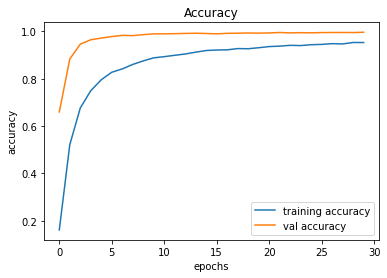

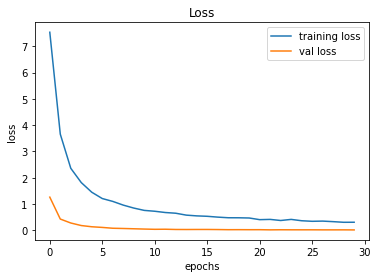

In [30]:
#Display of the accuracy and the loss values
import matplotlib.pyplot as plt

plt.figure(0)
plt.plot(history.history['acc'], label='training accuracy')
plt.plot(history.history['val_acc'], label='val accuracy')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()

plt.figure(1)
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()

In [32]:
#Predicting with the test data
y_test=pd.read_csv(base_path+"Test.csv")
labels=y_test['Path'].values
y_test=y_test['ClassId'].values


data=[]

for f in labels:
    image=cv2.imread(base_path+f, cv2.IMREAD_GRAYSCALE)
#             image_from_array = Image.fromarray(image, 'L')
#     print(base_path+f)
    image = cv2.resize(image, (height, width))
    data.append(np.array(image))

testX=np.array(data)
testX = testX[:,:,:,np.newaxis]
testX = testX.astype('float32')/255 
pred = model.predict(testX)

In [33]:
pred = np.argmax(pred,axis=1)

In [34]:
#Accuracy with the test data
from sklearn.metrics import accuracy_score
accuracy_score(y_test, pred)

0.9786223277909739

In [35]:
labelNames = open("signnames.csv").read().strip().split("\n")[1:]
labelNames = [l.split(",")[1] for l in labelNames]

In [43]:
os.path.join(save_path,timestr)

'./trafficsignnet.model\\20220116-202148'

In [61]:
# evaluate the network
print("[INFO] evaluating network...")
predictions = model.predict(testX)
print(classification_report(y_test,pred, target_names=labelNames))

# save the network
timestr = time.strftime("%Y%m%d-%H%M%S")
print("[INFO] serializing network to '{}.{}'...".format(save_path,timestr))
# save_path = os.path.sep.join(save_path,)
model.save(os.path.join(save_path,timestr))
# tf.keras.models.save_model(model,os.path.sep.join([save_path,timestr]))

[INFO] evaluating network...
                                                    precision    recall  f1-score   support

                              Speed limit (20km/h)       1.00      1.00      1.00        60
                              Speed limit (30km/h)       0.97      1.00      0.98       720
                              Speed limit (50km/h)       0.98      0.98      0.98       750
                              Speed limit (60km/h)       0.99      0.95      0.97       450
                              Speed limit (70km/h)       0.99      0.98      0.99       660
                              Speed limit (80km/h)       0.96      0.98      0.97       630
                       End of speed limit (80km/h)       0.99      0.99      0.99       150
                             Speed limit (100km/h)       0.99      0.99      0.99       450
                             Speed limit (120km/h)       0.99      1.00      0.99       450
                                        No passing

# Tester to load YOLO model and run detection and classification

In [46]:
# import the necessary packages
from tensorflow.keras.models import load_model
from skimage import transform
from skimage import exposure
from skimage import io
from imutils import paths
import numpy as np
import argparse
import imutils
import random
import cv2
import os
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

In [47]:
#function to plot an image
def plot_img(image, label,size=[6.4,4.8]):
    plt.figure(figsize=size)
    plt.axis(False)
    plt.title(label)
    plt.imshow(image)
    return

In [83]:
#function to predict label for each input box

def predict_label(model, roi, labelNames):
    try:
        image = cv2.resize(roi,(32, 32))
    except:
        return "0"
    image = image[np.newaxis,:,:,np.newaxis]
    image = np.array(image).astype("float32") / 255.0
    
    # make predictions
    preds = model.predict(image)
    if np.max(preds)>0.75:
        j = preds.argmax(axis=1)[0]
        label = labelNames[j]
    else:
        label = "others"
    
    return label

In [84]:
#function to draw boxes and labels on the first input image

def detected_image(image_path, bbs, labels):
    image = io.imread(image_path)
    for box,label in zip(bbs,labels):
        cv2.rectangle(image, (int(box[0]), int(box[1])), (int(box[0] + box[2]), int(box[1] + box[3])), [172 , 10, 127], 2)
        cv2.putText(image, label, (int(box[0] + box[2]), int(box[1] + box[3])), cv2.FONT_HERSHEY_DUPLEX,0.75, (255, 255, 0), 2)
        
    return image

In [85]:
#function to crop box
def crop_roi(image,box):
    h, w = image.shape[:2]
    x_center, y_center = (box[0] * w), (box[1] * h)
    box_width, box_height = (box[2] * w), (box[3] * h)
    x_min, y_min = (x_center - box_width/2), (y_center - box_height/2)
    roi = image[int(y_min):int(y_min+box_height), int(x_min):int(x_min+box_width)]
    return roi, [x_min, y_min,box_width, box_height]

In [86]:
image_path = "D:\GTSRB Dataset\gtsrb\captured_frames\\frame8696.jpg"
output_path = "D:\\GTSRB Dataset\\gtsrb\\test_output"
model_name = "D:\\GTSRB Dataset\\gtsrb\\trafficsignnet.model\\20220116-202944"

[INFO] loading model...


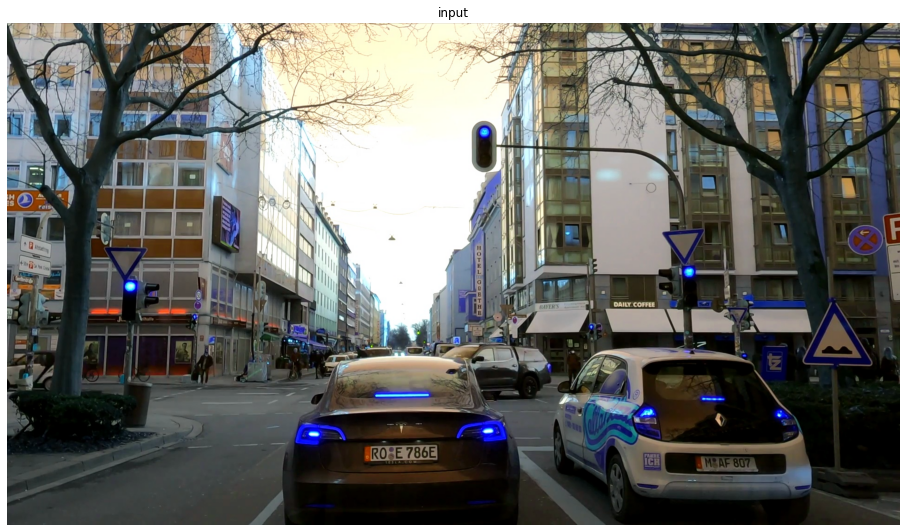

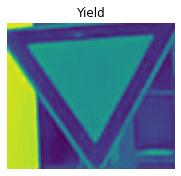

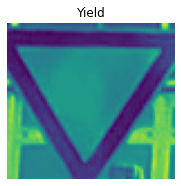

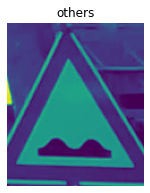

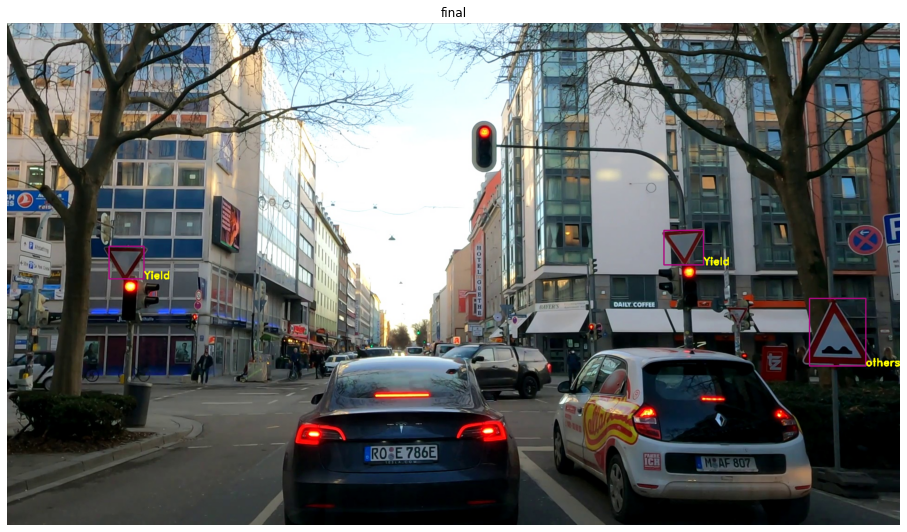

In [88]:
class_ids = []
confidences = []
boxes = []
rois = []
labels = []
bbs=[]

print("[INFO] loading model...")
model = load_model(model_name)

#yolo setup
net = cv2.dnn.readNet("yolov4-tiny_training_last_alz.weights", "yolov4-tiny_training.cfg")
layer_names = net.getLayerNames()
output_layers = [layer_names[i - 1] for i in net.getUnconnectedOutLayers()]
# print(output_layers)
confidence_threshold = 0.5

#forward pass yolo
image = cv2.imread(image_path)
plot_img(image, "input", [16,12])
blob = cv2.dnn.blobFromImage(image, 0.004, (416, 416), (0, 0, 0), True, crop=False)
net.setInput(blob)
outs = net.forward(output_layers)

#reading again since classfier performing better on skimage
image=cv2.imread(image_path,cv2.IMREAD_GRAYSCALE)

for out in outs:
    #     print(out.shape)
    for detection in out:
    #         print(len(detection))
        confidence = np.max(detection[5:])
        
        if confidence > confidence_threshold:
        #             print(confidence)
            roi, box = crop_roi(image,detection)
            confidences.append(float(confidence))
            rois.append(roi)
            boxes.append(box)



#adjust overlaps
indexes = cv2.dnn.NMSBoxes(boxes, confidences, 0.5, 0.4)

# load the label names
labelNames = open("signnames.csv").read().strip().split("\n")[1:]
labelNames = [l.split(",")[1] for l in labelNames]

for i,roi in enumerate(rois):
    if i in indexes:
        label = predict_label(model, roi,labelNames)
        plot_img(roi, label,[3,3])
        labels.append(label)
        bbs.append(boxes[i])
        
image = detected_image(image_path, bbs, labels)    
plot_img(image, "final", [16,12])
io.imsave(os.path.join(output_path,image_path.split("\\")[-1]),image)

# Video Tester

In [89]:
video_path = "D:\\GTSRB Dataset\\gtsrb\\video_input\\munich.mp4"
output_path = "D:\\GTSRB Dataset\\gtsrb\\video_output\\new_model"
model_name = "D:\\GTSRB Dataset\\gtsrb\\trafficsignnet.model\\20220116-202944"
path = os.path.join(output_path,video_path.split("\\")[-1])
os.makedirs(path, exist_ok=True)

In [90]:
import time
start_time = time.time()
frame_count = 0
tfps = 30
cap = cv2.VideoCapture(video_path)
curr_frame = 0

print ("Set 1: ", str(round(time.time()-start_time, 2)))
start_time = time.time()

Set 1:  0.04


In [91]:
print("[INFO] loading model...")
model = load_model(model_name)
print ("Set 2: ", str(round(time.time()-start_time, 2)))
start_time = time.time()

#yolo setup
net = cv2.dnn.readNet("yolov4-tiny_training_last_alz.weights", "yolov4-tiny_training.cfg")
layer_names = net.getLayerNames()
output_layers = [layer_names[i - 1] for i in net.getUnconnectedOutLayers()]
# print(output_layers)
confidence_threshold = 0.5
print ("Set 3: ", str(round(time.time()-start_time, 2)))

[INFO] loading model...
Set 2:  4.89
Set 3:  0.03


In [92]:
# load the label names
labelNames = open("signnames.csv").read().strip().split("\n")[1:]
labelNames = [l.split(",")[1] for l in labelNames]

In [93]:
while(True):
    start_time = time.time()
    ret, frame = cap.read()
    if not ret:
        break
    elif np.count_nonzero(np.array(frame.shape))<3:
        continue
    i+=1
    # print ("Set 4: ", str(round(time.time()-start_time, 2)))
    if i%5 == 0:
        try:
            start_time = time.time()

            curr_frame +=1
            image_path = 'captured_frames/frame'+str(curr_frame)+'.jpg'
            cv2.imwrite('captured_frames/frame'+str(curr_frame)+'.jpg',frame)
            #         img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            # print ("Set 3: ", str(round(time.time(), 2)))
            class_ids = []
            confidences = []
            boxes = []
            rois = []
            labels = []
            bbs=[]


            #forward pass yolo
            image = cv2.imread(image_path)
            blob = cv2.dnn.blobFromImage(image, 0.00392, (416, 416), (0, 0, 0), True, crop=False)
            net.setInput(blob)
            outs = net.forward(output_layers)

            #reading again since classfier performing better on skimage
            image=cv2.imread(image_path,cv2.IMREAD_GRAYSCALE)

            for out in outs:
                for detection in out:
                    confidence = np.max(detection[5:])

                    if confidence > confidence_threshold:
                        roi, box = crop_roi(image,detection)
                        confidences.append(float(confidence))
                        rois.append(roi)
                        boxes.append(box)

            #adjust overlaps
            indexes = cv2.dnn.NMSBoxes(boxes, confidences, 0.5, 0.4)

            for i,roi in enumerate(rois):
                if i in indexes:
                    label = predict_label(model, roi, labelNames)
                    labels.append(label)
                    bbs.append(boxes[i])

            image = detected_image(image_path, bbs, labels)    
            io.imsave(path+"\\frame"+str(curr_frame),image)
            elapsed_time = time.time() - start_time
            fps = 1/elapsed_time
            print ("frame", curr_frame)
            print ("fps: ", str(round(fps, 2)))
        except ValueError:
            continue
cap.release()
cv2.destroyAllWindows()

KeyboardInterrupt: 

In [ ]:
video_path = "D:\\GTSRB Dataset\\gtsrb\\video_input\\munich.mp4"
output_path = "D:\\GTSRB Dataset\\gtsrb\\video_output"
model_name = "./trafficsignnet.model"

In [ ]:
path = os.path.join(output_path,video_path.split("\\")[-1])
os.makedirs(path, exist_ok=True)
print(path+"\\frame"+str(curr_frame))
io.imsave(path+"\\frame"+str(curr_frame),image)